<hr>

# AI Workflow Capstone - AAVAIL - **Part 2 - Model Building and Selection**

Student: `Alexey Tyurin`<br>
Date: `1/17/2024`
<hr>

### Introduction
This case study focuses on data transformations and models in time-series forecasting. Time-series data, prevalent in finance, signal processing, and weather forecasting, involves predicting future values based on past observations. This study will guide you through applying supervised learning techniques to such data, encouraging exploration of time-series modeling tools. The objective is to forecast metrics like purchases, views, or revenue, closely tied to business opportunities.

### Time-series analysis
In our time-series analysis, we primarily use TensorFlow, scikit-learn, and Spark ML for model implementation. This approach is vital for predicting future business metrics like monthly revenue. For such predictions, feature engineering is key. We can create features from past revenue data (e.g., previous day, week, month, three months) to help models like random forests or boosting algorithms identify data patterns. This feature engineering is often tailored to each specific case.

Although our current goal is to predict the next point in a time-series, considering future projections, such as three months ahead, can be beneficial. This can be done using recursive forecasting, where predictions are iteratively added to the feature matrix, or ensemble forecasting, which uses separate models for each forecast. A combination of these methods can also be effective.

It's important to note that linear regression assumptions may not hold in time-series due to auto-correlation, especially when features are mainly revenue-based and highly correlated. More sophisticated models, combined with well-crafted features, are generally more effective in this context.

### Deliverables for Data Engineering in Time-Series Forecasting:

**Feature Engineering with Rolling Window**:
- Utilize historical data, as future values (unrealized) are unknown.
Generate additional features based on historical values for each data point. This involves creating a rolling window of past data (e.g., daily, weekly, monthly) to capture trends and patterns in the historical revenue data.


**Target Value with Rolling Window**:
- Standardize the target across models to be the sum of revenues over the next 30 days for any given point in time.
In supervised learning, this target is represented as a single number, encapsulating the total forecasted revenue for the forthcoming thirty days. This approach ensures consistency and comparability across different models and forecasting techniques.

### Tasks
1. State the different modeling approaches that you will compare to address the business opportunity.
2. Iterate on your suite of possible models by modifying data transformations, pipeline architectures, hyperparameters and other relevant factors.
3. Re-train your model on all of the data using the selected approach and prepare it for deployment.
4. Articulate your findings in a summary report.

**HINT:** *To standardize the approach across models ensure that your model predicts the next 30 days for any given point in time. For supervised learning, the total revenue over the next thirty days can be represented as a single number.*

In [31]:
# Libraries

import pandas as pd
import numpy as np
import os, re, time, joblib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from IPython.display import Image
from cslib import fetch_data
from logger import _update_train_log
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve, ShuffleSplit


In [32]:
# CONSTANTS

IMAGE_DIR = os.path.join(".", "images")
MODEL_DIR = os.path.join(".", "models")
LOG_DIR = os.path.join(".", "logs")
DATA_TRAIN_DIR = os.path.join(".", "cs-train")
DATA_PROD_DIR = os.path.join(".", "cs-production")

MODEL_VERSION = 0.1
MODEL_NOTE = 'initial model'
TOP_COUNTRIES = 10
DEV = True

In [33]:
df = fetch_data(DATA_TRAIN_DIR)

In [34]:
# Filter top 10 countries by revenue
top_countries = df.groupby('country')['price'].sum().nlargest(TOP_COUNTRIES).index.tolist()
filtered_df = df[df['country'].isin(top_countries)]

# Group by and aggregate
ds = filtered_df.groupby(['country', 'invoice_date']).agg(
    purchases=('invoice', 'size'),
    unique_invoices=('invoice', 'nunique'),
    unique_streams=('stream_id', 'nunique'),
    total_views=('times_viewed', 'sum'),
    revenue=('price', 'sum')
).reset_index()

# Generate a complete date range
date_range = pd.date_range(df['invoice_date'].min(), df['invoice_date'].max(), freq='1D')

# Create a DataFrame from the product of date_range and unique countries in the filtered data
complete_index = pd.MultiIndex.from_product([date_range, top_countries], names=['invoice_date', 'country'])
complete_df = pd.DataFrame(index=complete_index).reset_index()

# Merge with the aggregated DataFrame
ds = complete_df.merge(ds, on=['invoice_date', 'country'], how='left').fillna(0)

# Adding totals across all countries
totals = ds.drop(['country'], axis=1).groupby('invoice_date').sum().reset_index()
totals['country'] = 'Total'
ds = pd.concat([ds, totals])

ds.sample(5)


,invoice_date,country,purchases,unique_invoices,unique_streams,total_views,revenue
875,2018-02-23,Spain,0.0,0.0,0.0,0.0,0.00
4395,2019-02-10,Spain,0.0,0.0,0.0,0.0,0.00
4184,2019-01-20,Norway,0.0,0.0,0.0,0.0,0.00
2849,2018-09-08,Netherlands,0.0,0.0,0.0,0.0,0.00
5132,2019-04-25,Germany,8.0,1.0,8.0,77.0,38.27


In [35]:
def engineer_rolling_features(X, shift_days, attributes, func='sum', engineer_target=False):
    """
    Engineer features and/or target based on a rolling window.

    Parameters:
    X (DataFrame): Input data frame.
    shift_days (int): Number of days for rolling window.
    attributes (list): List of column names to be transformed.
    func (str): Function to apply in rolling window ('sum' or 'mean').
    engineer_target (bool): If True, shift the result to engineer target.

    Returns:
    DataFrame: Transformed data frame.
    """
    X_indexed = X.set_index('invoice_date')
    freq = f'{shift_days}D'

    if func == 'sum':
        X_transformed = X_indexed[attributes].rolling(freq, closed='left').sum()
    else:
        X_transformed = X_indexed[attributes].rolling(freq, closed='left').mean()

    if engineer_target:
        X_transformed = X_transformed.shift(-shift_days)

    suffix = f'_p{freq}' if engineer_target else f'_m{freq}'
    X_transformed = X_indexed.merge(X_transformed, 
                                    left_index=True,
                                    right_index=True,
                                    how='left',
                                    suffixes=['', suffix]).fillna(0).reset_index()
    return X_transformed


In [36]:
features = ds.columns.tolist()[2:-1]
all_features = []

for country in ds['country'].unique():
    temp = ds[ds['country'] == country].drop("country", axis=1)

    # Engineer features
    for shift in [7, 14, 28, 35, 54]:
        temp = engineer_rolling_features(temp, shift, ['revenue'])
    
    temp = engineer_rolling_features(temp, 30, features, func='mean')
    
    # Engineer target
    temp = engineer_rolling_features(temp, 30, ['revenue'], engineer_target=True)

    # Drop original features and keep only engineered ones
    engineered_cols = [col for col in temp.columns if '_m' in col or '_p' in col]
    temp = temp[['invoice_date'] + engineered_cols]
    temp['country'] = country

    all_features.append(temp)

# Concatenate all countries
ds = pd.concat(all_features)

In [37]:
for sub in ds['country'].unique():
    print(sub, ds[ds['country']==sub].shape)

United Kingdom (611, 12)
EIRE (611, 12)
Germany (611, 12)
France (611, 12)
Norway (611, 12)
Spain (611, 12)
Hong Kong (611, 12)
Portugal (611, 12)
Singapore (611, 12)
Netherlands (611, 12)
Total (611, 12)


### Model Selection

For each country a model is built and trained. Since the features have different scales, we need to scale the data. The algorithms explored are:

* Linear Regressor
* K Neighbors Regressor
* Stochastic Gradient Descent
* Random Forest Regressor
* Gradient Bossting Regressor
* Ada Boosting Regressor

For each algorithm we used scikit-learn `Pipeline` and `GridSearchCV` to fine tune the hyperparameters and find the optimal model.

In [38]:
def create_learning_curves(X, y, models, country):
    """
    Create learning curves for multiple regression models.
    """
    fig, axes = plt.subplots(2, 3, figsize=(12, 8), facecolor="white")
    axes = axes.ravel()  # Flatten the array for easy iteration

    for idx, (model_key, ax) in enumerate(zip(models.keys(), axes)):
        regressor = models[model_key]['regressor']
        best_params = models[model_key]['grid'].best_estimator_['reg'].get_params()

        if best_params is not None:
            regressor.set_params(**best_params)

        pipeline = Pipeline(steps=[("scaler", StandardScaler()), 
                                   ("reg", regressor)])
        
        train_sizes, train_scores, test_scores = learning_curve(pipeline, X, y,
                                                                cv=ShuffleSplit(n_splits=5, test_size=0.2, random_state=0), 
                                                                n_jobs=-1,
                                                                train_sizes=np.linspace(.1, 1.0, 10), 
                                                                scoring='r2') # 'neg_mean_squared_error', 'explained_variance'

        train_sizes_expanded = np.repeat(train_sizes, train_scores.shape[1])

        df_train = pd.DataFrame({'Train Size': train_sizes_expanded, 'Score': train_scores.flatten(), 'Set': 'Training'})
        df_test = pd.DataFrame({'Train Size': train_sizes_expanded, 'Score': test_scores.flatten(), 'Set': 'Cross-validation'})

        df = pd.concat([df_train, df_test])

        sns.lineplot(data=df, x='Train Size', y='Score', hue='Set', errorbar='sd', marker='o', palette=["red", "green"], ax=ax)

        ax.set_title(models[model_key]['name'])
        ax.set_xlabel('Training examples')
        ax.set_ylabel('R² (Coefficient of Determination)')
        ax.grid(True)
        ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda val, pos: '{:.0%}'.format(val)))
        ax.legend(loc='best')        
        
    plt.suptitle(country)
    plt.tight_layout()
    plt.savefig(os.path.join(IMAGE_DIR, f'{country}_learning_curves.png'), format='png', dpi=300)
    plt.close()


In [39]:
def plot_feature_importance(estimator, feature_names, country):
    """
    plot feature importance
    """
    
    fig, ax = plt.subplots(figsize=(8, 6), facecolor="white")

    feature_importance = estimator.best_estimator_["reg"].feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())

    data = pd.DataFrame({'name': feature_names, 'feature': feature_importance}).sort_values('feature')

    sns.barplot(data=data, x='feature', y='name', orient='h')
    ax.set_title(f'{country} - Variable Importance')
    ax.set_xlabel('Relative Importance')
    ax.set_ylabel('Variable')

    return

In [40]:
init_models = {
    'LNR': {'name': 'Linear Regressor',
            'regressor': LinearRegression(),
            'params': {'reg__fit_intercept': [True, False]},
            'grid': None},
    'KNR': {'name': 'K Neighbors Regressor',
            'regressor': KNeighborsRegressor(),
            'params': {'reg__n_neighbors': [3, 5, 7, 9, 11],
                       'reg__weights': ['uniform', 'distance'],
                       'reg__metric': ['euclidean', 'manhattan']},
            'grid': None},
    'RFR': {'name': 'Random Forest Regressor',
            'regressor': RandomForestRegressor(random_state=42),
            'params': {'reg__n_estimators': [10, 30, 50],
                       'reg__max_features': [3, 4, 5],
                       'reg__bootstrap': [True, False]},
            'grid': None},
    'SGD': {'name': 'Stochastic Gradient Regressor',
            'regressor': SGDRegressor(random_state=42),
            'params': {'reg__penalty': ['l1', 'l2', 'elasticnet'],
                       'reg__learning_rate': ['constant', 'optimal', 'invscaling']},
            'grid': None},
    'GBR': {'name': 'Gradient Boosting Regressor',
            'regressor': GradientBoostingRegressor(random_state=42),
            'params': {'reg__n_estimators': [10, 30, 50],
                       'reg__max_features': [3, 4, 5],
                       'reg__learning_rate': [1, 0.1, 0.01, 0.001]},
            'grid': None},
    'ABR': {'name': 'Ada Boosting Regressor',
            'regressor': AdaBoostRegressor(random_state=42),
            'params': {'reg__n_estimators': [10, 30, 50],
                       'reg__learning_rate': [1, 0.1, 0.01, 0.001]},
            'grid': None},
    }

In [41]:
# Train models for each country
for country in ds['country'].unique():
    time_start = time.time()
    models = init_models.copy()

    temp = ds[ds['country'] == country]
    X = temp.iloc[:, 1:-2]
    y = temp['revenue_p30D']

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

    min_rmse = np.inf

    for model in models:
        pipe = Pipeline(steps=[('scaler', StandardScaler()),
                               ('reg', models[model]['regressor'])])
                        
        grid = GridSearchCV(
                        pipe,
                        param_grid=models[model]['params'],
                        scoring='neg_mean_squared_error',
                        cv=5,
                        n_jobs=-1,
                        return_train_score=True)
                
        grid.fit(X_train, y_train)

        models[model]['grid'] = grid

        y_pred = grid.predict(X_valid)
        rmse = np.sqrt(mean_squared_error(y_pred, y_valid))
        r2 = r2_score(y_pred, y_valid)
        if rmse < min_rmse:
            min_rmse = rmse
            min_r2 = r2
            opt_model = model

    create_learning_curves(X, y, models, country)
    print(f"Country: {country} ...best model: {models[model]['name']}, rmse = {min_rmse:,.2f}, R^2 = {min_r2:.1%}")

    models[opt_model]['grid'].fit(X, y)

    if not os.path.exists(MODEL_DIR):
        os.makedirs(MODEL_DIR)
    
    saved_model = os.path.join(MODEL_DIR, f"test-{country}-model-{str(MODEL_VERSION).replace('.', '_')}.joblib")
    joblib.dump(models[opt_model]['grid'], saved_model)

    if 'feature_importances_' in dir(models[opt_model]['grid'].best_estimator_["reg"]):
        plot_feature_importance(models[opt_model]['grid'], feature_names=X.columns.tolist(), country=country)
    else:
        plot_feature_importance(models["RFR"]['grid'], feature_names=X.columns.tolist(), country=country)
    
    plt.savefig(os.path.join(IMAGE_DIR, f'{country}_features_importance.png'), format='png', dpi=300)
    plt.close()
    
    m, s = divmod(time.time()-time_start, 60)
    h, m = divmod(m, 60)
    runtime = "%03d:%02d:%02d"%(h, m, s)
            
    ## update log
    _update_train_log(tag=country, 
                      algorithm=models[model]['name'],
                      score={'rmse': min_rmse, 'r2': min_r2},
                      runtime=runtime,
                      model_version=MODEL_VERSION,
                      model_note=MODEL_NOTE,
                      dev=DEV,
                      verbose=False)

Country: United Kingdom ...best model: Ada Boosting Regressor, rmse = 17,045.27, R^2 = 95.5%
Country: EIRE ...best model: Ada Boosting Regressor, rmse = 1,197.13, R^2 = 89.7%
Country: Germany ...best model: Ada Boosting Regressor, rmse = 413.21, R^2 = 84.2%
Country: France ...best model: Ada Boosting Regressor, rmse = 375.87, R^2 = 85.0%
Country: Norway ...best model: Ada Boosting Regressor, rmse = 7,753.57, R^2 = -738.6%
Country: Spain ...best model: Ada Boosting Regressor, rmse = 162.43, R^2 = 96.0%
Country: Hong Kong ...best model: Ada Boosting Regressor, rmse = 431.88, R^2 = 90.2%
Country: Portugal ...best model: Ada Boosting Regressor, rmse = 256.51, R^2 = 96.1%
Country: Singapore ...best model: Ada Boosting Regressor, rmse = 2,173.78, R^2 = -533.8%
Country: Netherlands ...best model: Ada Boosting Regressor, rmse = 158.23, R^2 = 75.2%
Country: Total ...best model: Ada Boosting Regressor, rmse = 12,967.77, R^2 = 97.6%


### Model Evaluation

* Cross - Validation score
* Learning curves

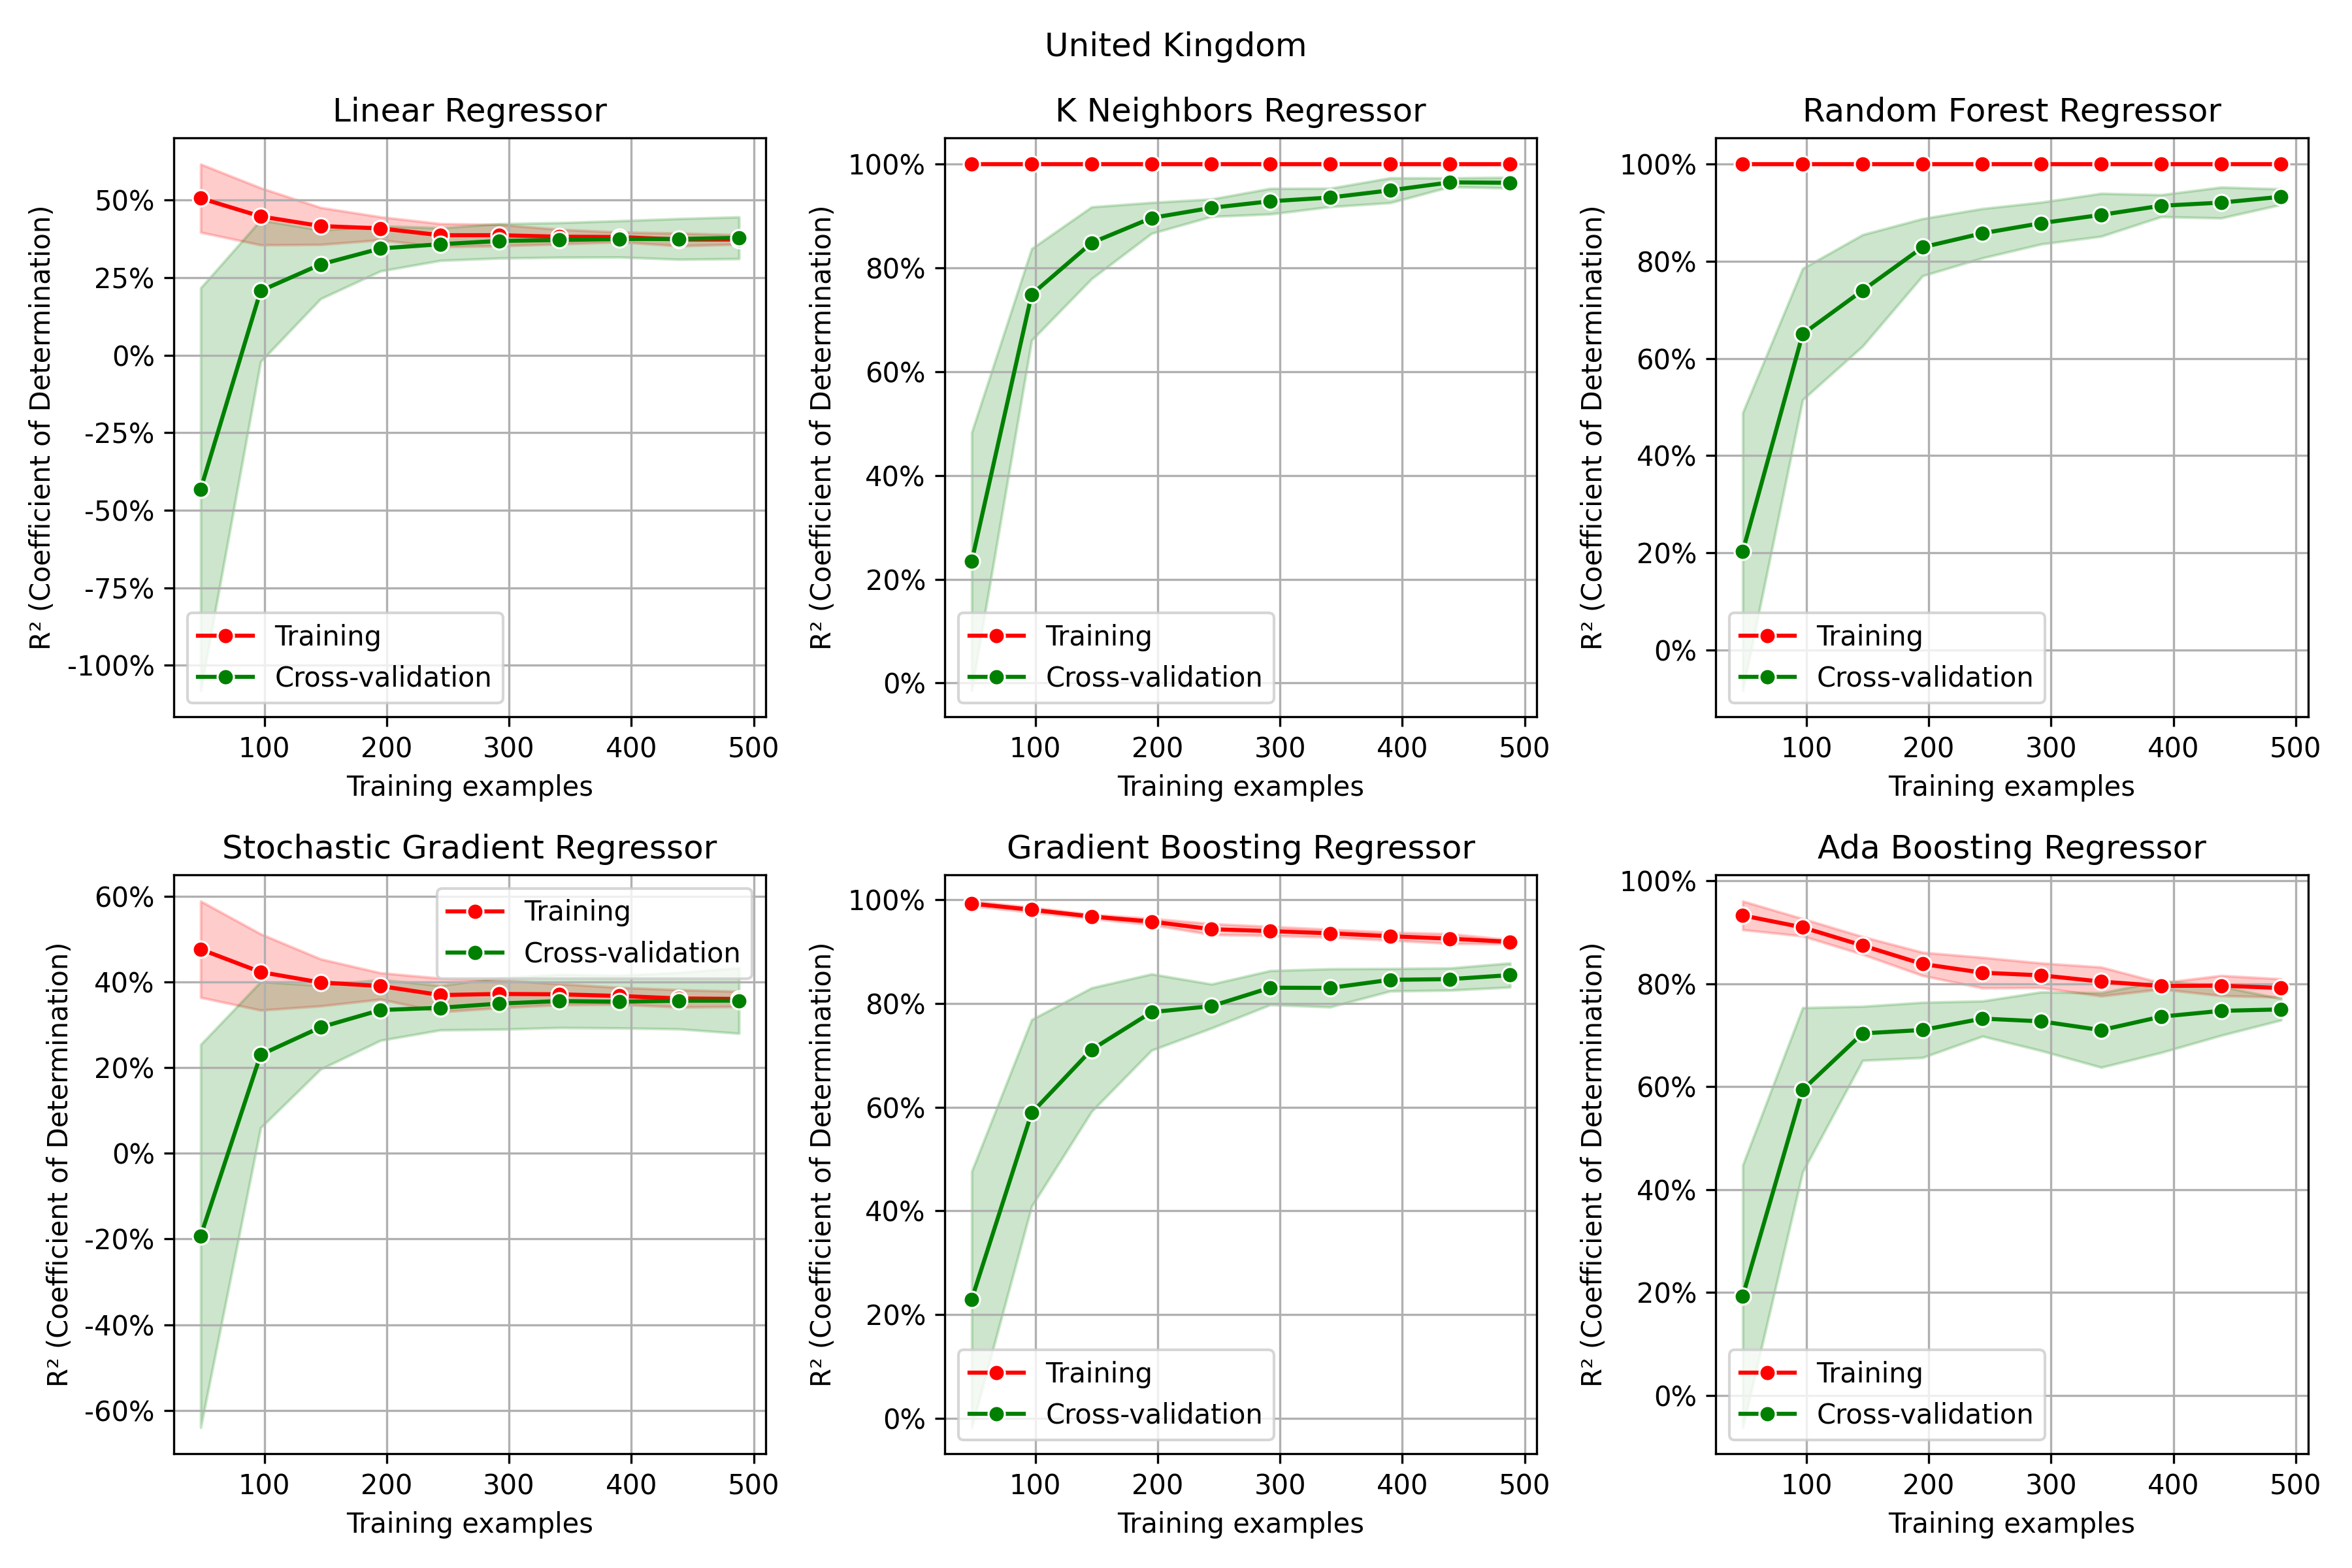

In [42]:
Image("./images/United Kingdom_learning_curves.png",width=800, height=800)

### Features Importance

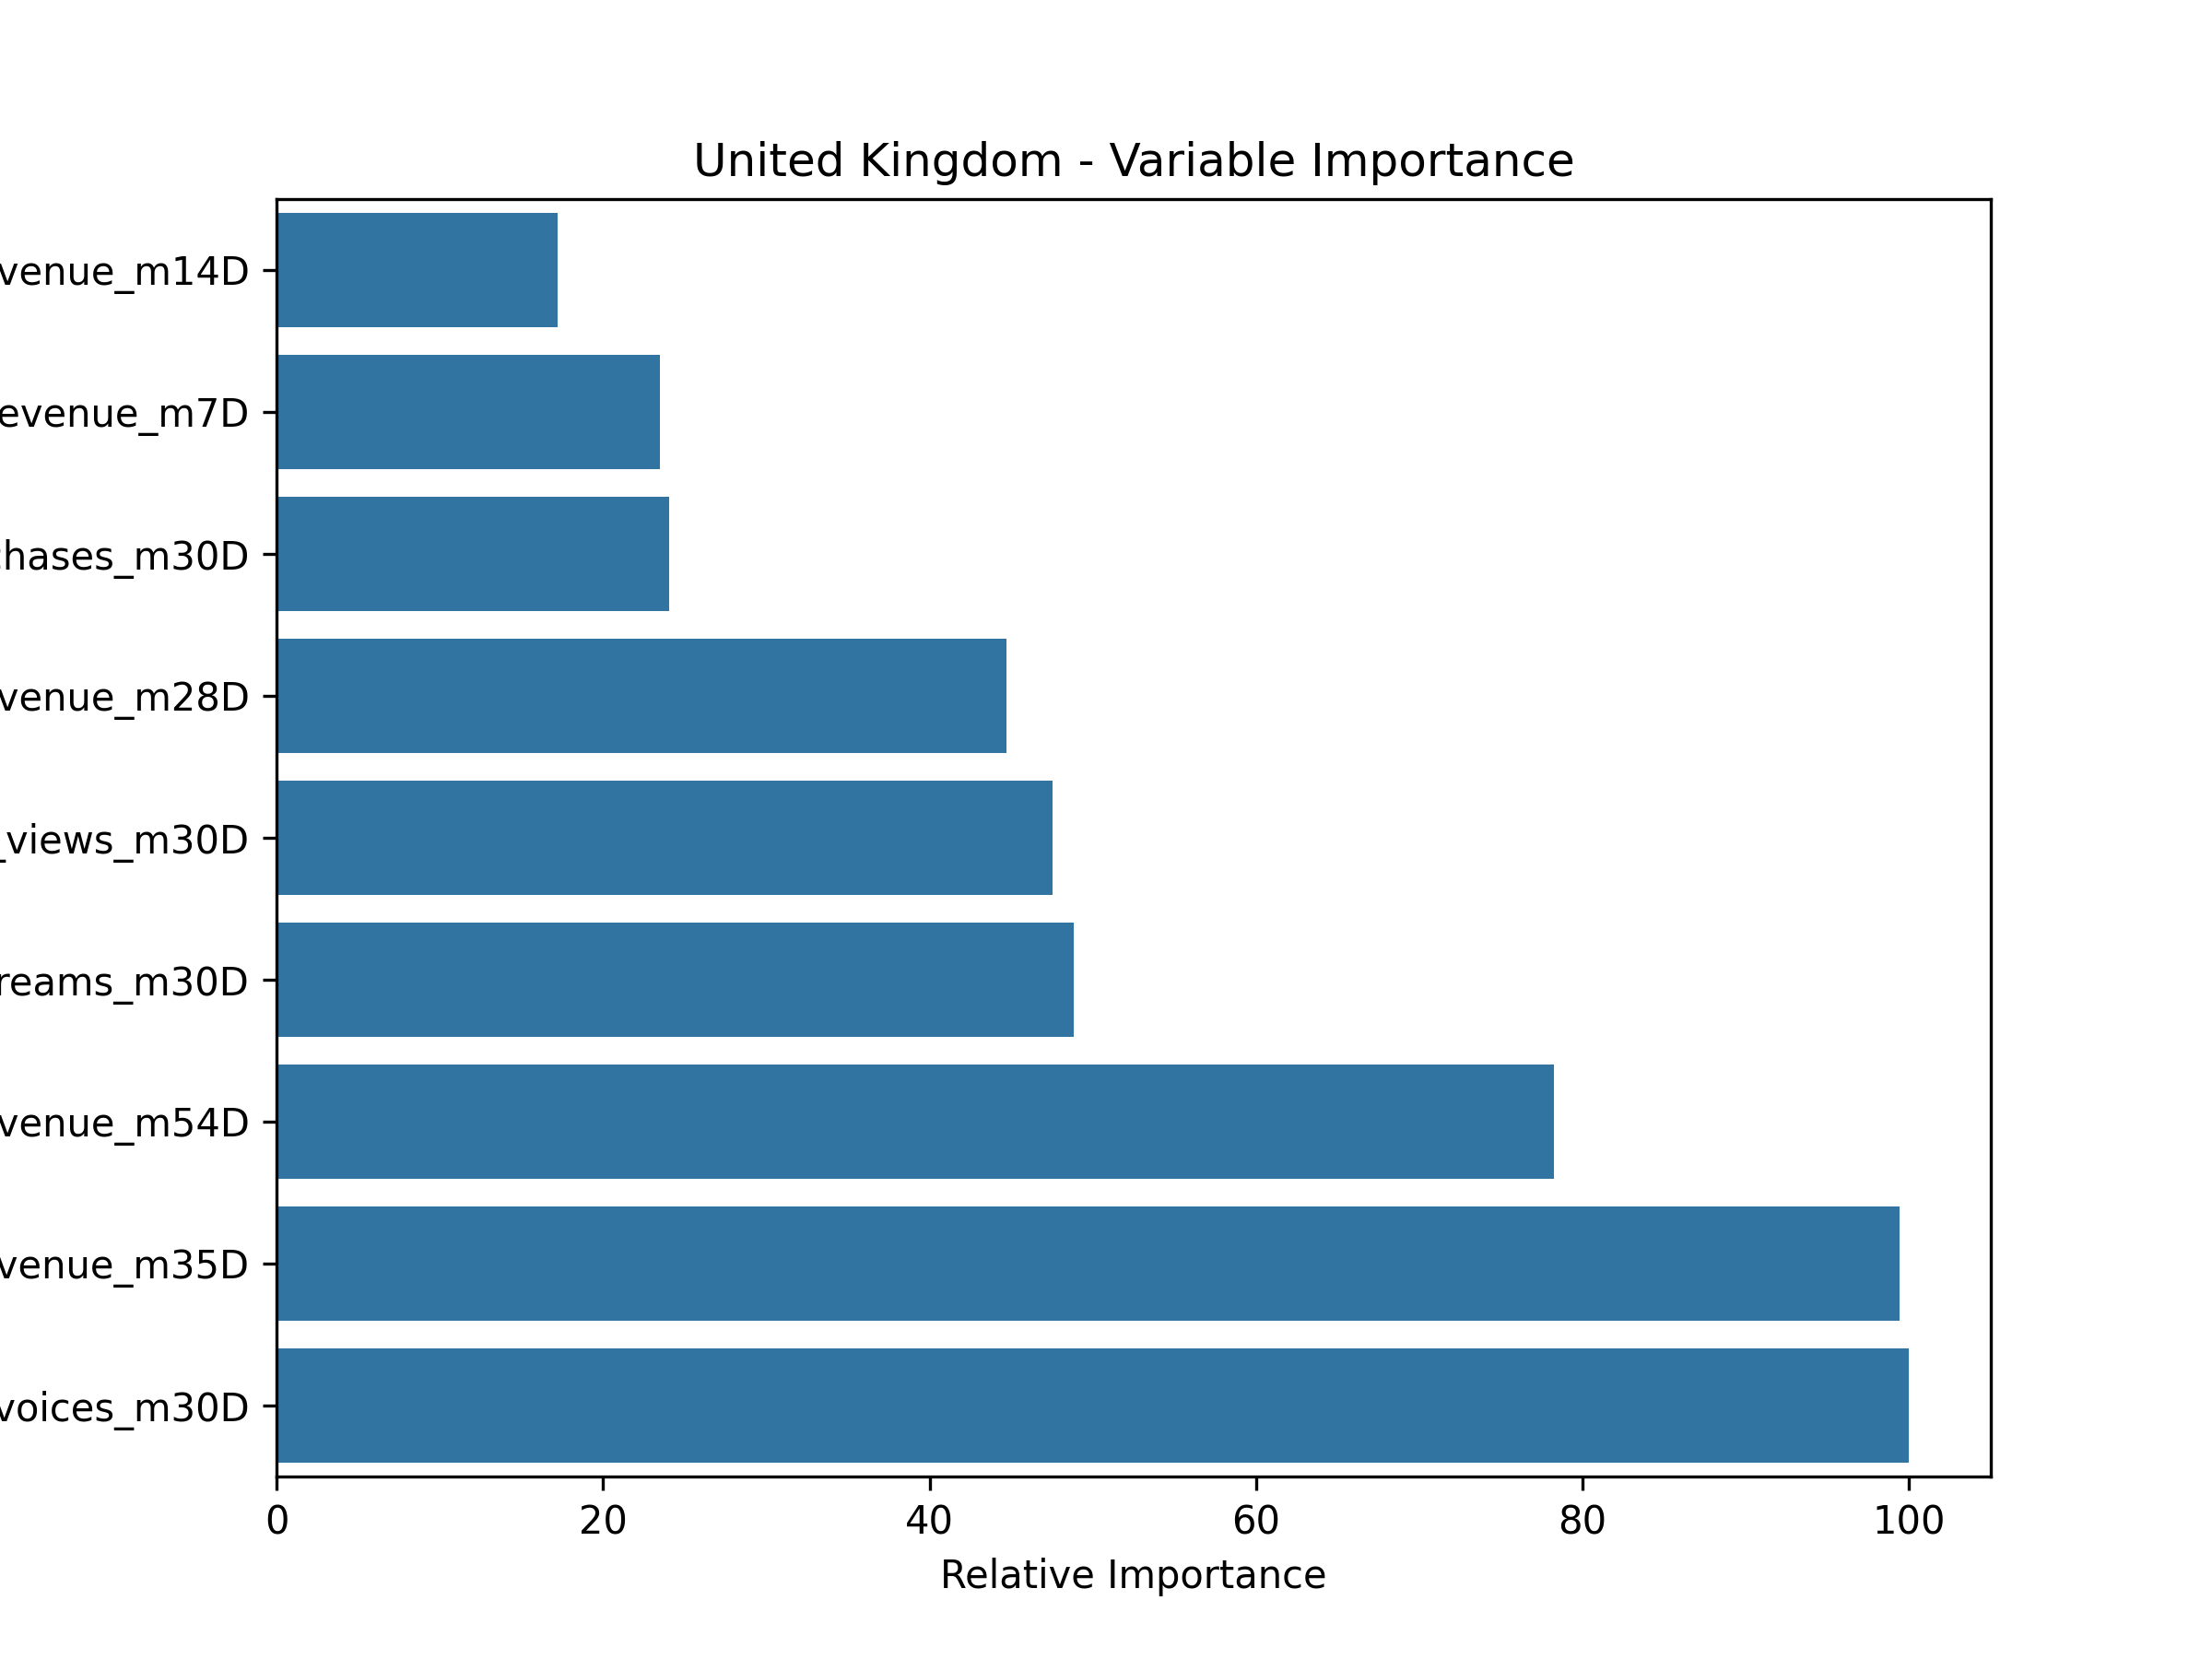

In [43]:
Image("./images/United Kingdom_features_importance.png",width=800, height=800)

### Model Overview

In [44]:
def model_load(model_dir=MODEL_DIR, dev=DEV, verbose=True):
    """
    load models
    """
    
    if verbose:
        print("Loading Models")
    
    if dev:
        prefix = "test"
    else:
        prefix = "prod"
    
    if not os.path.exists(MODEL_DIR):
        raise Exception("Opps! Model dir does not exist")
    
    ## list model files from model directory
    models = [f for f in os.listdir(model_dir) if re.search(prefix,f)]

    if len(models) == 0:
        raise Exception(f"Models with prefix {prefix} cannot be found did you train?")
    
    ## load models
    all_models = {}
    for model in models:
        all_models[re.split("-", model)[1]] = joblib.load(os.path.join(model_dir, model))
        
    return(all_models)

In [45]:
models = model_load()

labels = {}
for key, item in models.items():
    labels[key.upper()] = type(item.best_estimator_["reg"]).__name__
    
bm = pd.DataFrame.from_dict(labels, orient="index", columns=["model"])
bm

Loading Models


,model
EIRE,RandomForestRegressor
FRANCE,RandomForestRegressor
GERMANY,KNeighborsRegressor
HONG KONG,RandomForestRegressor
NETHERLANDS,RandomForestRegressor
NORWAY,AdaBoostRegressor
PORTUGAL,RandomForestRegressor
SINGAPORE,RandomForestRegressor
SPAIN,KNeighborsRegressor
TOTAL,KNeighborsRegressor


[EOF]